In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=8dc5c314172695d8bf4e85a38faec9f8f2e6c838260f1625ca48f42628109221
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql import functions as F

spark = SparkSession.builder \
    .appName("QueryGrouping") \
    .getOrCreate()

In [3]:
data = spark.read.csv("/content/partaa.csv", header=True, inferSchema=True)

In [4]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_token(token):
    pos_tag = nltk.pos_tag([token])[0][1][0].upper()
    pos_tag = pos_tag if pos_tag in ['N', 'V', 'R', 'J'] else 'n'
    return lemmatizer.lemmatize(token, pos=pos_tag)


In [6]:
data.show(5)

+---------+--------+----+-----+---+----+------------+------------------+------+----------------+--------------+--------------------+--------------------+
|BlockName|Category|Year|Month|Day|Crop|DistrictName|         QueryType|Season|          Sector|     StateName|           QueryText|              KccAns|
+---------+--------+----+-----+---+----+------------+------------------+------+----------------+--------------+--------------------+--------------------+
|     0   |       0|2006|    1| 17|1275|       SAGAR|                99|  RABI|    HORTICULTURE|MADHYA PRADESH|how to control fl...|spray planofix4ml...|
|     0   |       0|2006|    1| 17| 964|       SAGAR|Disease Management|  RABI|ANIMAL HUSBANDRY|MADHYA PRADESH|how tyo control d...|                NULL|
|     0   |       0|2006|    1| 17|1279|       SAGAR|                76|  RABI|    HORTICULTURE|MADHYA PRADESH|how to control fr...|should be spray p...|
|     0   |       0|2006|    1| 17|1064|       SAGAR|                 3|  RA

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [8]:
# Task 1: Finding number of calls per hour
calls_per_hour = data.withColumn("hour", split(col("Day"), " ")[1].substr(1, 2)).groupBy("hour").count()

# Task 2: Frequency of QueryType
query_type_frequency = data.groupBy("QueryType").count()

# Task 3: Frequency of Crop
crop_frequency = data.groupBy("Crop").count().orderBy(col("count").desc())

# Task 4: Frequency of crop category
crop_category_frequency = data.groupBy("Category").count().orderBy(col("count").desc())

# Task 5: Frequency of different Sector
sector_frequency = data.groupBy("Sector").count()

# results
calls_per_hour.show(10)
query_type_frequency.show(10)
crop_frequency.show(10)
crop_category_frequency.show(10)
sector_frequency.show(10)


+----+------+
|hour| count|
+----+------+
|NULL|332263|
+----+------+

+-----------------+-----+
|        QueryType|count|
+-----------------+-----+
|               51|   17|
|               15|  185|
|               11|  114|
|          Poultry|   31|
|               29|41086|
|               87|  140|
| Plant Protection|   70|
|                3|22315|
|Field Preparation|   23|
|               34|   14|
+-----------------+-----+
only showing top 10 rows

+------------+------+
|        Crop| count|
+------------+------+
|        9999|166704|
|Cotton Kapas| 19503|
|       Wheat| 14110|
|      Tomato|  7550|
|      Others|  7211|
|        1280|  7192|
|        1279|  6419|
|       Onion|  6023|
|         Ber|  5646|
|        1037|  5040|
+------------+------+
only showing top 10 rows

+-----------+------+
|   Category| count|
+-----------+------+
|          0|332261|
|Fiber Crops|     1|
| Vegetables|     1|
+-----------+------+

+----------------+------+
|          Sector| count|
+----

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
#Task 6: Query Clustering
def preprocess_text(text):
    if text is None:
        return ""
    tokens = text.lower().split()
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = [token for token in tokens if token.isalpha() and token not in stopwords]
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(tokens)

preprocess_udf = udf(preprocess_text, StringType())

data = data.withColumn("clean_text", preprocess_udf("QueryText"))

# data = data.drop("tokens")
tokenizer = Tokenizer(inputCol="clean_text", outputCol="tokens")
data = tokenizer.transform(data)

# data = data.drop("filtered_tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
data = remover.transform(data)

hashingTF = HashingTF(inputCol="filtered_tokens", outputCol="rawFeatures")
tf_data = hashingTF.transform(data)


In [11]:
idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(tf_data)
tfidf_data = idf_model.transform(tf_data)

In [12]:
kmeans = KMeans(featuresCol="features", k=5, seed=42)
model = kmeans.fit(tfidf_data)
predictions = model.transform(tfidf_data)

results = predictions.select("QueryText", "prediction")
results.show(truncate=False)

+----------------------------------------------------------------------+----------+
|QueryText                                                             |prediction|
+----------------------------------------------------------------------+----------+
|how to control flower drop in bottelgourd                             |0         |
|how tyo control diseases in buffalo                                   |0         |
|how to control fruit borer in brinjal                                 |3         |
|how to control of yellow moisac in moong                              |0         |
|how to control white fly in brinjal                                   |0         |
|how to control termite in wheat                                       |0         |
|how to control chilli thrips                                          |0         |
|how to increase milk in buffalo                                       |0         |
|how to control sucking pest in bottle gourd                           |1   

In [13]:
results.write.csv("clustering_results.csv")

In [14]:
unique_predictions_count = results.select("prediction").distinct().count()
print("Number of unique predictions:", unique_predictions_count)

Number of unique predictions: 5


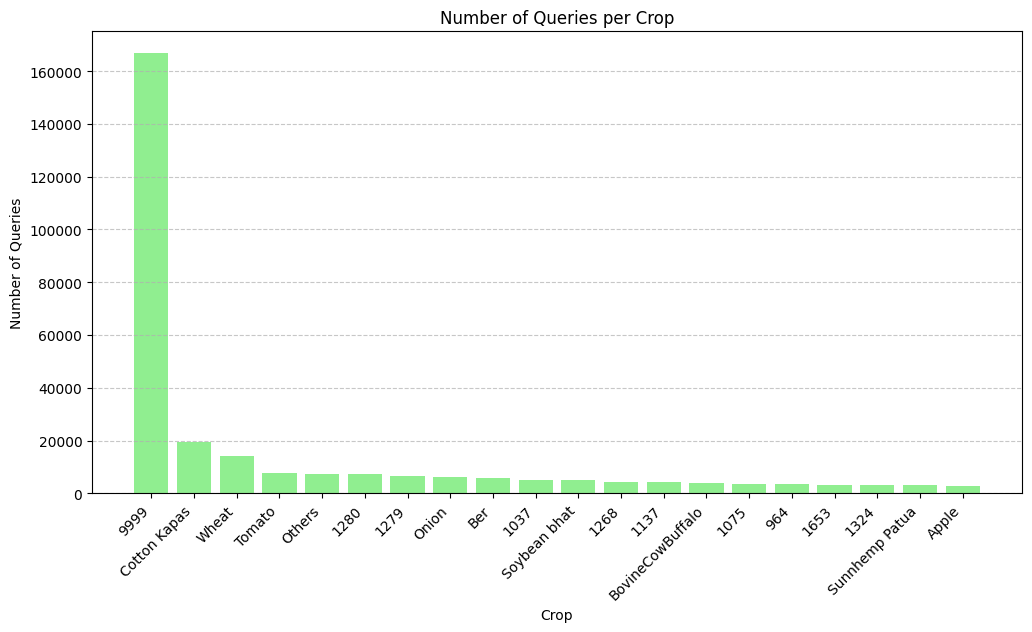

In [15]:
import matplotlib.pyplot as plt

queries_per_crop = data.groupBy("Crop").count().orderBy("count", ascending=False)

queries_per_crop_pd = queries_per_crop.limit(20).toPandas()

plt.figure(figsize=(12, 6))
plt.bar(queries_per_crop_pd["Crop"], queries_per_crop_pd["count"], color='lightgreen')
plt.xlabel('Crop')
plt.ylabel('Number of Queries')
plt.title('Number of Queries per Crop')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

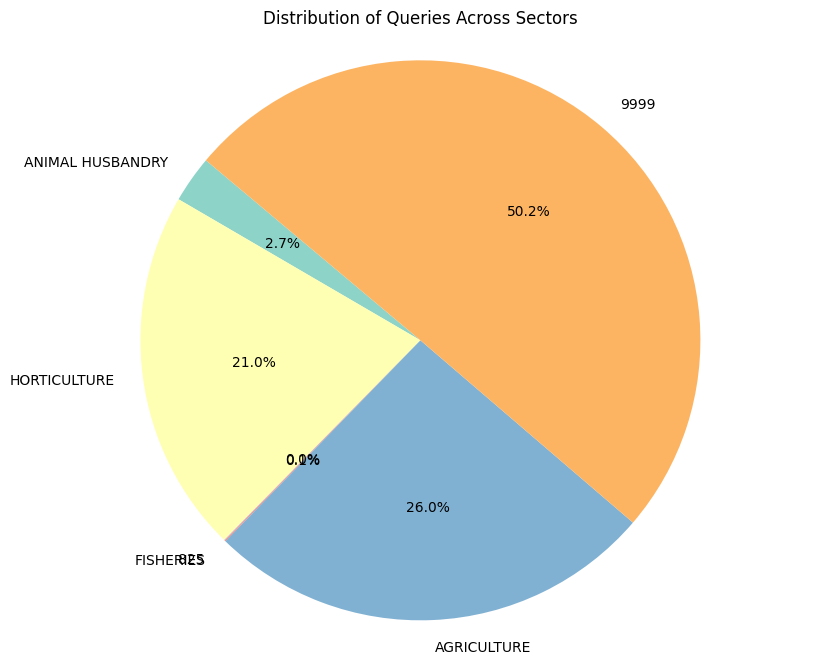

In [17]:
import seaborn as sns

grouped_data = data.groupBy("Sector").count()

grouped_data_pd = grouped_data.toPandas()

plt.figure(figsize=(10, 8))
plt.pie(grouped_data_pd["count"], labels=grouped_data_pd["Sector"], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3"))
plt.axis('equal')
plt.title("Distribution of Queries Across Sectors")
plt.show()


In [ ]:
# Stop SparkSession
spark.stop()